### Purpose
This notebook creates bar chart and heatmaps of weekly patterns in daily ridership on the mta

The notenbook starts with the output from [01-mta-project1](01-mta-project1.ipynb)

In [1]:
from copy import copy

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Import Previous Results

In [2]:
final_df = pd.read_pickle('final_df.pkl')
final_df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,...,EXITS,STATION_LINENAME,DATETIME,DIFF_HRS,DIFF_ENTRIES,DIFF_EXITS,DAY,TIME_TIME,TIME_INT,RIDERSHIP
1,35984,H038,R350,00-00-00,LIVONIA AV,L,BMT,07/06/2019,05:00:00,REGULAR,...,3509838,"(LIVONIA AV, L)",2019-07-06 05:00:00,04:00:00,2.0,23.0,5,05:00:00,5,25.0
2,35985,H038,R350,00-00-00,LIVONIA AV,L,BMT,07/06/2019,09:00:00,REGULAR,...,3509889,"(LIVONIA AV, L)",2019-07-06 09:00:00,04:00:00,43.0,51.0,5,09:00:00,9,94.0
3,35986,H038,R350,00-00-00,LIVONIA AV,L,BMT,07/06/2019,13:00:00,REGULAR,...,3509949,"(LIVONIA AV, L)",2019-07-06 13:00:00,04:00:00,53.0,60.0,5,13:00:00,13,113.0
4,35987,H038,R350,00-00-00,LIVONIA AV,L,BMT,07/06/2019,17:00:00,REGULAR,...,3510012,"(LIVONIA AV, L)",2019-07-06 17:00:00,04:00:00,65.0,63.0,5,17:00:00,17,128.0
5,35988,H038,R350,00-00-00,LIVONIA AV,L,BMT,07/06/2019,21:00:00,REGULAR,...,3510056,"(LIVONIA AV, L)",2019-07-06 21:00:00,04:00:00,30.0,44.0,5,21:00:00,21,74.0


#### Wrangling
compute total traffic (the sum of entries and exits)
aggregate values broken down by time and daily totals
aggregate median values for entries, exits, and total trafic by day of the week

In [3]:
total_traffic = final_df["DIFF_ENTRIES"] + final_df["DIFF_EXITS"]
final_df['TOTAL_TRAF'] = total_traffic

station_median_data_hourly = final_df.groupby(['STATION','TIME']).agg({'DIFF_ENTRIES':'median',
                                                                      'DIFF_EXITS':'median',
                                                                      'TOTAL_TRAF':'median'}).reset_index()

station_median_data_daily_hourly = final_df.groupby(['STATION','TIME','DAY']).agg({'DIFF_ENTRIES':'median',
                                                                                   'DIFF_EXITS':'median',
                                                                                   'TOTAL_TRAF':'median'}).reset_index()



#### Ploting median values for entries and exits broken down by time

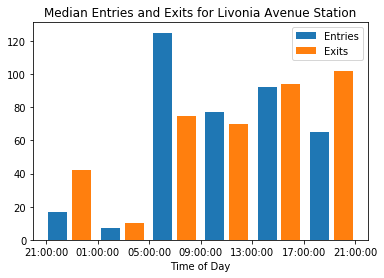

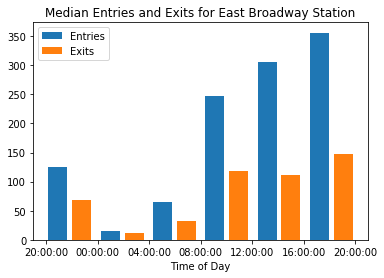

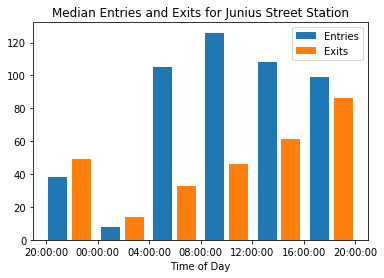

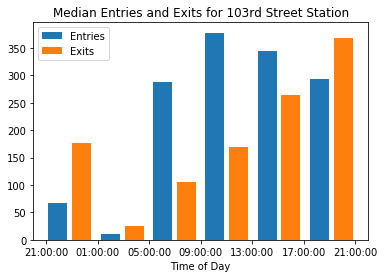

In [4]:
stations_to_plot = ['LIVONIA AV', 'EAST BROADWAY', 'JUNIUS ST', '103 ST']
plain_station_names = ['Livonia Avenue', 'East Broadway', 'Junius Street', '103rd Street']

for station, plain_station in zip(stations_to_plot, plain_station_names):
    filtered_df = station_median_data_hourly[station_median_data_hourly['STATION'] == station]
    filtered_df = filtered_df[filtered_df['TIME'].map(lambda x: str(x).endswith('00:00'))]
        
    labels = filtered_df['TIME'].map(str).to_list()
    xs=np.linspace(1,12,len(labels))
    xs_col1 = xs-.5
    xs_col2 = xs+.5
    xs_labels = np.linspace(0,13,len(labels)+1)
    labels = [labels[-1]] + labels
    
    plt.figure()
    plt.bar(xs_col1, filtered_df['DIFF_ENTRIES'], label='Entries')
    plt.bar(xs_col2, filtered_df['DIFF_EXITS'], label='Exits')

    plt.xticks(xs_labels, labels)
    plt.title('Median Entries and Exits for {} Station'.format(plain_station))
    plt.xlabel('Time of Day')
    plt.legend()
    plt.savefig('data/{}_median_hourly.png'.format(plain_station.replace(' ', '_')), dpi=300)

#### Plotting Median Traffic by Day and Time

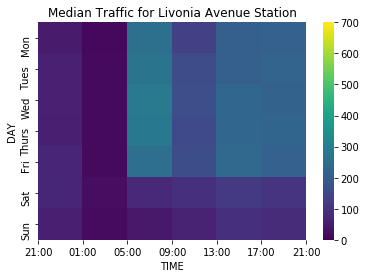

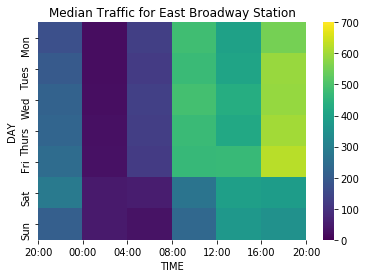

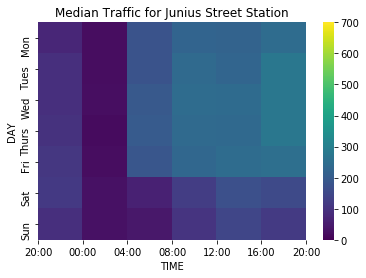

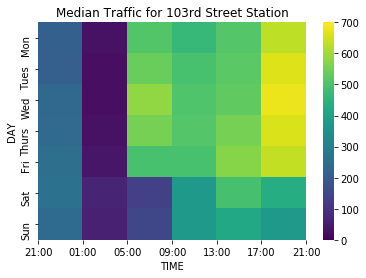

In [5]:
ylabels = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
for station, plain_station in zip(stations_to_plot, plain_station_names):
    
    heat_map_df = station_median_data_daily_hourly[station_median_data_daily_hourly['STATION'] == station]
    heat_map_df = heat_map_df[heat_map_df['TIME'].map(lambda x: str(x).endswith('00:00'))]
    heat_map_df['TIME'] = heat_map_df['TIME'].map(lambda x: str(x)[0:-3])
        
    pivoted =  heat_map_df.pivot(index='DAY', columns='TIME', values='TOTAL_TRAF')
    
    labels = list(heat_map_df['TIME'].unique())
    labels = [labels[-1]] + labels
    
    plt.figure()
    heat = sns.heatmap(pivoted, cmap='viridis', vmin=0, vmax=700, yticklabels=ylabels)
    heat.set_title('Median Traffic for {} Station'.format(plain_station))
    plt.xticks(np.linspace(0,6,7), labels)
    
    plt.savefig('data/{}_heatmap.png'.format(plain_station.replace(' ', '_')), dpi=300, transparent=True)
